You belong to the data team at a local research hospital. You've been tasked with developing a means to help doctors diagnose breast cancer. You've been given data about biopsied breast cells; where it is benign (not harmful) or malignant (cancerous).

- What features of a cell are the largest drivers of malignancy? Build a model that predicts whether a given biopsied breast cell is benign or malignant.
- What features drive your false positive rate for your model you derived above, what features drive your false negative rate? 
- How would a physician use your product?
- There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

In addition to well-documented, extendable, and reusable code we are looking for a coherent data-story. This is a deliberately open-ended question that provides a chance to showcase your EDA, analysis, and presentation skills. The expectation is that you should spend no more than 4 hours on this task, and no more than 1 one preparing a presentation. 



In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix


In [64]:
df = pd.read_csv('breast-cancer-wisconsin.txt')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15855 non-null int64
ID                             15855 non-null int64
Clump Thickness                15855 non-null int64
Uniformity of Cell Size        15827 non-null object
Uniformity of Cell Shape       15827 non-null object
Marginal Adhesion              15827 non-null object
Single Epithelial Cell Size    15827 non-null object
Bare Nuclei                    15827 non-null object
Bland Chromatin                15827 non-null object
Normal Nucleoli                15827 non-null object
Mitoses                        15827 non-null object
Class                          15827 non-null object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB
None


,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


In [65]:
df['Class'].value_counts()

4          15164
2            456
40           151
?             23
No idea       17
#             11
20             5
Name: Class, dtype: int64

In [66]:
df = df[df['Class']!='No idea']
df = df[df['Class']!='?']
df = df[df['Class']!='#']
df = df[~df['Class'].isnull()]

df['Class'] = df['Class'].map({'4':0, '2':1, '40':0, '20':1})

In [67]:

df[df['Bare Nuclei']!='?']['Bare Nuclei'].value_counts()

10     5123
8      3006
3      2019
5      2016
1      1394
2      1027
6      1000
100      46
50       26
80       26
30       24
4        19
20       10
9         9
7         8
60        7
Name: Bare Nuclei, dtype: int64

In [68]:
# See of 'Bare Nuclei' what the distribution of '1' values look like
df[df['Class']==1]['Bare Nuclei'].value_counts()

1     385
2      21
3      14
?      14
5      10
10      7
4       6
8       2
20      1
7       1
Name: Bare Nuclei, dtype: int64

In [69]:
df[df['Bare Nuclei']=='?']

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
157,157,1057067,1,1,1,1,1,?,1,1,1,1
1144,1144,1238464,1,1,1,1,1,?,2,1,1,1
1799,1799,169356,3,1,1,1,2,?,3,1,1,1
2398,2398,563649,8,8,8,1,2,?,6,10,1,0
3727,3727,61634,5,4,3,1,2,?,2,3,1,1
5059,5059,1096800,6,6,6,9,6,?,7,8,1,1
6563,6563,1241232,3,1,4,1,2,?,3,1,1,1
6752,6752,1193683,1,1,2,1,3,?,1,1,1,1
7122,7122,432809,3,1,3,1,2,?,2,1,1,1
7539,7539,1184840,1,1,3,1,2,?,2,1,1,1


### Below is a guess for what to replace it with, since 'Bare Nuclei' seems to contain a lot of the elusive '1' states, so I replaced it with the most popular value of 1 for the subclass of 1 states

This choice is likely to have a big effect since there are so few '1' categories.  Do feel free to revisit this choice as you are optimizing the model

In [70]:
df['Bare Nuclei'] = df['Bare Nuclei'].replace('?', 1)

In [72]:
df['Class'].value_counts()

0    15315
1      461
Name: Class, dtype: int64

In [74]:
461/(15315+461)

# 3% imbalanced data!

0.02922160243407708

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15776 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15776 non-null int64
ID                             15776 non-null int64
Clump Thickness                15776 non-null int64
Uniformity of Cell Size        15776 non-null object
Uniformity of Cell Shape       15776 non-null object
Marginal Adhesion              15776 non-null object
Single Epithelial Cell Size    15776 non-null object
Bare Nuclei                    15776 non-null object
Bland Chromatin                15776 non-null object
Normal Nucleoli                15776 non-null object
Mitoses                        15776 non-null object
Class                          15776 non-null int64
dtypes: int64(4), object(8)
memory usage: 1.6+ MB


In [77]:
df = df.drop(['Index', 'ID'], axis=1) #head()

In [87]:
### According to docs, all values should be integers from 1 to 10

for column in df.columns:
    df[column] = df[column].astype(int)
    for value in df[column].unique():
        if value > 10:
             df[column].replace(value,value/10, inplace=True)
            

In [88]:
df['Clump Thickness'].unique()

array([ 7,  6,  8,  5, 10,  3,  4,  1,  2,  9])

In [89]:
for column in df.columns:
    print(column, df[column].value_counts())

Clump Thickness 10    5083
7     4051
8     3061
5     1135
3     1113
6     1043
1      144
4       83
2       50
9       13
Name: Clump Thickness, dtype: int64
Uniformity of Cell Size 10    4085
6     4048
5     2039
8     2038
3     1064
4     1042
9     1012
1      382
2       47
7       19
Name: Uniformity of Cell Size, dtype: int64
Uniformity of Cell Shape 4     4069
5     3048
6     3042
10    2070
7     2038
3     1064
1      351
2       59
8       28
9        7
Name: Uniformity of Cell Shape, dtype: int64
Marginal Adhesion 3     4077
10    3082
4     2049
6     2025
1     1401
2     1060
5     1032
7     1020
8       25
9        5
Name: Marginal Adhesion, dtype: int64
Single Epithelial Cell Size 3     6102
4     5077
2     1391
6     1047
10    1037
8     1022
1       47
5       39
7       12
9        2
Name: Single Epithelial Cell Size, dtype: int64
Bare Nuclei 10    5169
8     3032
3     2043
5     2042
1     1410
2     1037
6     1007
4       19
9        9
7        8
Name: 

# Okay let's model this thing

In [167]:
y = df['Class']
X = df.drop('Class', axis=1)

In [168]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2)

In [169]:
d_train = xgb.DMatrix(data=X_train, label=y_train)
d_test = xgb.DMatrix(data=X_test)#, label=y_test)

In [170]:
params = {'max_depth': 6, 
          'objective': 'binary:logistic',
          'eta': 0.1,
   #       'n_estimators':1000,
          'booster': 'gbtree',
          'eval_metric': 'logloss'}

In [171]:
t = time.time()

num_rounds = 100
xgb_model = xgb.train(params, d_train, num_rounds)

print('Elapsed Time: ', time.time()-t)

[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[17:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

In [172]:
y_pred_xgb = xgb_model.predict(d_test)

y_pred_xgb

array([3.2944247e-04, 2.5838675e-04, 3.1285643e-04, ..., 1.8137036e-04,
       8.1122053e-05, 2.5838675e-04], dtype=float32)

In [173]:
y_pred_xgb

array([3.2944247e-04, 2.5838675e-04, 3.1285643e-04, ..., 1.8137036e-04,
       8.1122053e-05, 2.5838675e-04], dtype=float32)

In [174]:
y_pred_xgb = y_pred_xgb.round()

In [175]:

accuracy = accuracy_score(y_test, y_pred_xgb), 
f1 = f1_score(y_test, y_pred_xgb), 
roc_auc = roc_auc_score(y_test, y_pred_xgb)

accuracy, f1, roc_auc

((0.9987325728770595,), (0.9807692307692307,), 0.9855504050194317)

In [176]:
confusion_matrix(y_test, y_pred_xgb)

array([[3050,    1],
       [   3,  102]])

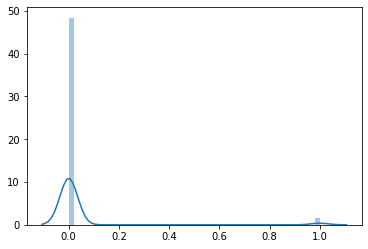

In [177]:
sns.distplot(y_pred_xgb.round())

In [178]:
xgb_model.fe

AttributeError: 'Booster' object has no attribute 'fe'